In [1]:
from qiskit import QuantumCircuit, QuantumRegister
import qiskit

import rustworkx
from rustworkx.visualization import graphviz_draw
from rustworkx.rustworkx import simple_cycles
import collections
from collections import Counter
from typing import List
import copy


In [2]:
import os, sys

sys.path.append(os.path.abspath("../"))

num_i = 2
num_a = 2
num_o = 2
num_g = 5

In [3]:
from helperfunctions.reversecircuitgraph import uncompute_input_nodes_greedy, add_uncomp_input_node, uncomp_all_operations_using_circuitgraph
from helperfunctions.circuitgraphfunctions import get_computation_graph, get_uncomp_circuit
from helperfunctions.graphhelper import breakdown_qubit, edge_attr, node_attr, node_matcher, edge_matcher
from helperfunctions.uncompfunctions import add_uncomputation, add_uncomputation_step

from helperfunctions.constants import StringConstants, ListConstants

In [4]:
INPUT = StringConstants.INPUT.value
ANCILLA = StringConstants.ANCILLA.value
OUTPUT = StringConstants.OUTPUT.value

INIT = StringConstants.INIT.value
COMP = StringConstants.COMP.value
UNCOMP = StringConstants.UNCOMP.value

TARGET = StringConstants.TARGET.value
CONTROL = StringConstants.CONTROL.value
ANTIDEP = StringConstants.ANTIDEP.value

NON_QFREE = ListConstants.NON_QFREE.value

In [5]:
def small_example_circuit():
    i = QuantumRegister(num_i, 'i')
    o = QuantumRegister(num_o, 'o')
    a = QuantumRegister(num_a, 'a')

    circ = QuantumCircuit(i,o,a)


    circ.cx(i[1],i[0])
    circ.cx(i[0],a[0])
    circ.cx(i[1],a[1])


    circ.cx(a[1],i[0])
    circ.cx(a[0],i[1])

    for x in range(num_i):
        circ.cx(i[x], o[x])

    
    return circ


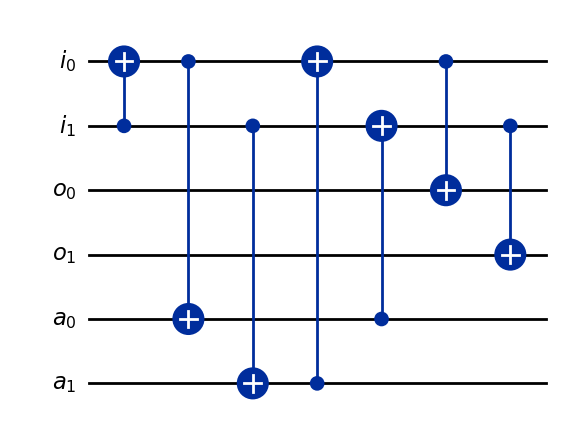

In [6]:
circ = small_example_circuit()


circ.draw('mpl')

In [7]:
qubits =  [breakdown_qubit(q)['label'] for q in circ.qubits]

ancillas_list = qubits[-num_a:] 
inputs_list = qubits[:num_i]
outpus_list = qubits[num_i:num_i+num_o]


# output_list = qubits[num_i:num_i+num_o]
print(ancillas_list)
print(inputs_list)
# circ.data[0].label = COMP
print(circ.data[0].label)

['a0', 'a1']
['i0', 'i1']
None


In [8]:
def get_bennetts_uncomp_without_reordering(circuit: QuantumCircuit, ancillas: List, num_gates:int):
    instructions = list(circuit.data[:num_gates])

    ctr = 0
    for ins in instructions:
        anc = [1 for q in ins.qubits if breakdown_qubit(q)['label'] in ancillas_list]
        if len(anc) == 0:
            ctr += 1
        else:
            break
    print(f'The first {ctr} gates are between input qubits, they can be ignored in bennetts uncomp.')
    
    valid_instructions = instructions[ctr:]
    valid_instructions.reverse()

    benentts_uncomp_circuit = circuit.copy()
    for ins in valid_instructions:
        benentts_uncomp_circuit.append(ins)

    return benentts_uncomp_circuit
    
    pass

In [9]:
def remove_nodes_not_in_bennetts(all_uncomp_graph:rustworkx.PyDiGraph, bennetts_uncomp_graph:rustworkx.PyDiGraph, matcher_func):
    # Pre-compute all potential matches for faster lookup
    nodes_to_remove = []
    new_uncomp_graph = all_uncomp_graph.copy()

    # Optional: If nodes have attributes that can be hashed for quicker comparison
    # Create a set or dictionary for faster lookups
    # This assumes node objects have comparable attributes
    
    # For each node in the first graph
    for node in all_uncomp_graph.nodes():
        # Use any() for short-circuit evaluation
        if not any(matcher_func(node, b_node) for b_node in bennetts_uncomp_graph.nodes()):
            nodes_to_remove.append(node.index)
    
    # Remove nodes in reverse order to avoid index shifting
    for node_index in sorted(nodes_to_remove, reverse=True):
        new_uncomp_graph.remove_node(node_index)

    return new_uncomp_graph
    


In [10]:
# [print(d) for d in circ.data[:num_g]]

bennetts_ucirc = get_bennetts_uncomp_without_reordering(circ, ancillas_list, num_g)

The first 1 gates are between input qubits, they can be ignored in bennetts uncomp.


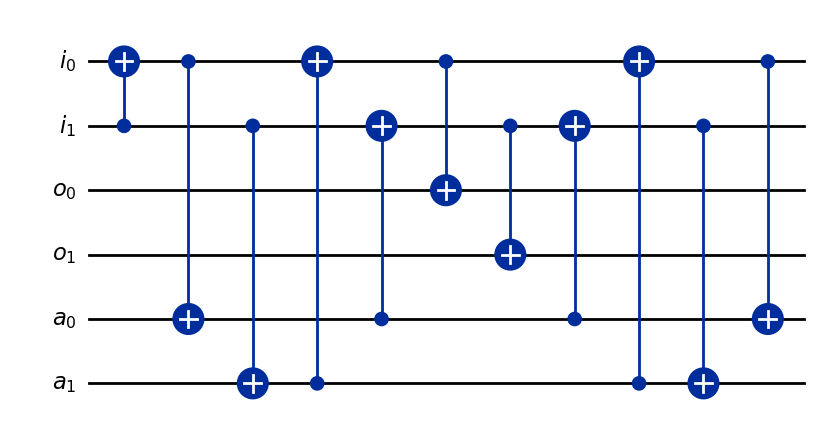

In [11]:
bennetts_ucirc.draw('mpl')

In [12]:
all_uncomp_cg = uncomp_all_operations_using_circuitgraph(get_computation_graph(circ, ancillas_list, outpus_list))
all_uncomp_circ = get_uncomp_circuit(all_uncomp_cg)

Building uncomp circuit from circuit graph: 100%|██████████| 18/18 [00:00<00:00, 89985.07it/s]


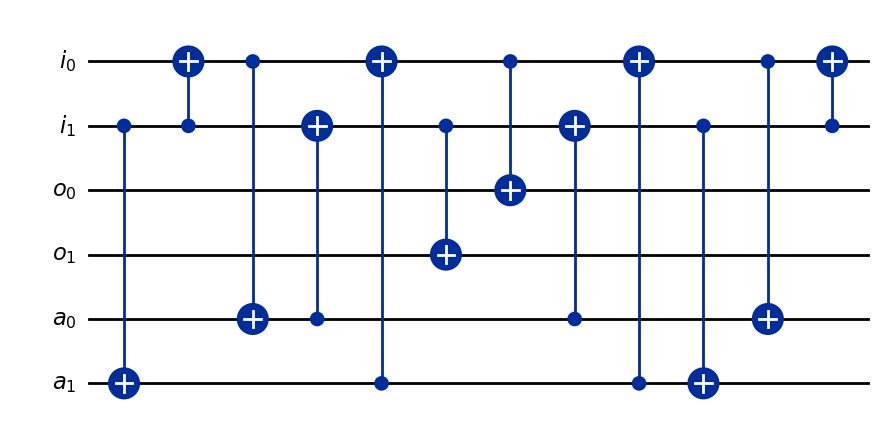

In [13]:
all_uncomp_circ.draw('mpl')

In [14]:
bennetts_uncomp_cg = get_computation_graph(bennetts_ucirc, ancillas_list, outpus_list)

Adding Nodes for Circuit: 100%|██████████| 11/11 [00:00<00:00, 60707.03it/s]


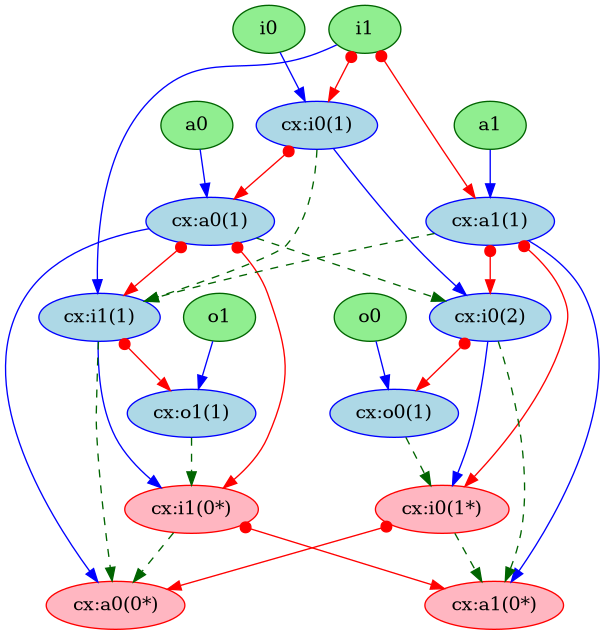

In [15]:
graphviz_draw(bennetts_uncomp_cg, node_attr_fn=node_attr, edge_attr_fn=edge_attr)

In [16]:
new_uncomp_cg = remove_nodes_not_in_bennetts(all_uncomp_cg, bennetts_uncomp_cg, node_matcher)

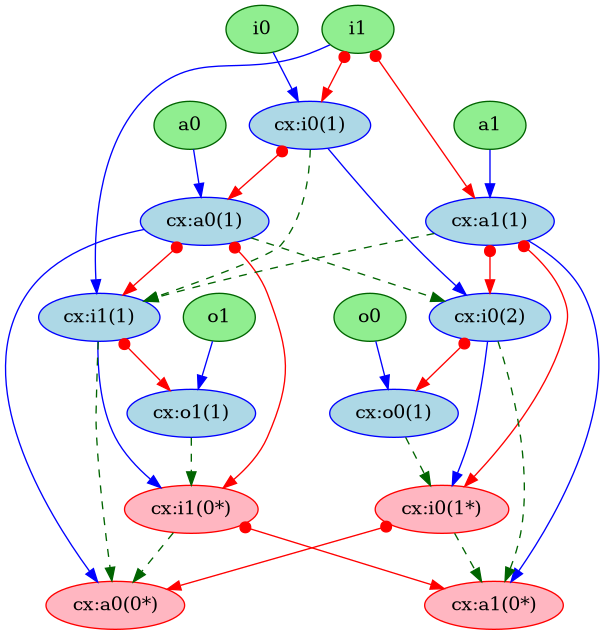

In [17]:
graphviz_draw(new_uncomp_cg, node_attr_fn=node_attr, edge_attr_fn=edge_attr)

In [18]:
ancilla_uncomp_cg, has_cycle = add_uncomputation(get_computation_graph(circ, ancillas_list, outpus_list), ancillas_list, allow_cycle=True)


Adding Nodes for Circuit: 100%|██████████| 7/7 [00:00<00:00, 35077.81it/s]


In [19]:
all_uncomp_circ_postbennetts = get_uncomp_circuit(new_uncomp_cg)

Building uncomp circuit from circuit graph: 100%|██████████| 17/17 [00:00<00:00, 85700.92it/s]


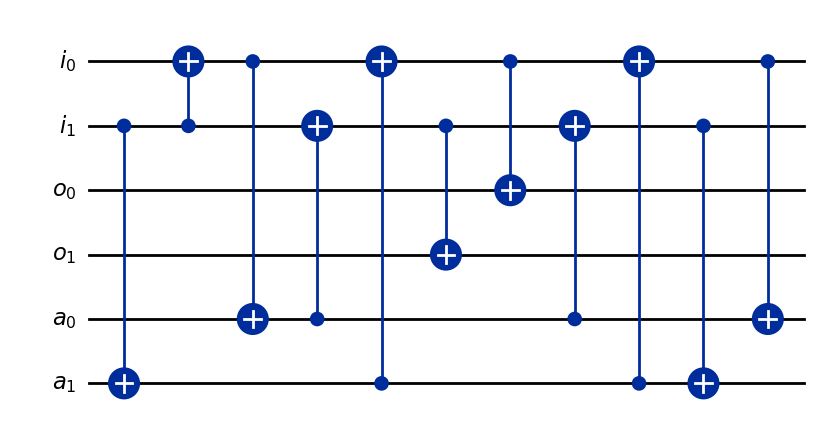

In [20]:
all_uncomp_circ_postbennetts.draw('mpl')